# Produção do Guaraná no Brasil

Tabela 6588 - Série histórica da estimativa anual da área plantada, área colhida, produção e rendimento médio dos produtos das lavouras

__Fonte:__ [IBGE - Levantamento Sistemático da Produção Agrícola](https://sidra.ibge.gov.br/tabela/6588#)

In [1]:
%matplotlib inline


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patheffects as pe
import seaborn as sns
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import geopandas as gpd


register_matplotlib_converters()
sns.set(rc={'figure.figsize':(11, 4)})
sns.set_style("ticks")

#### Leitura e pré-processamento da base

In [2]:
df = pd.read_excel("bases/Tabela 6588.xlsx", skiprows=4).rename({"Unnamed: 0": "estado"}, axis=1)

# -- 

df.drop(df.index[-1], inplace=True)
df = pd.melt(df, id_vars=["estado"], var_name="periodo", value_name="toneladas")
df.toneladas = df.toneladas.replace('...', np.nan)
df.toneladas = df.toneladas.replace('-', 0)
df.dropna(inplace=True)
df.toneladas = df.toneladas.astype(int)

Ajuste no formato da data:

In [3]:
meses = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 
         'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']

df.periodo = df.periodo.apply(lambda x: '{}/{}'.format(meses.index(x.split(' ')[0])+1, x.split(' ')[1]))
df.periodo = pd.to_datetime(df.periodo, format="%m/%Y")
df = df.set_index('periodo')

### Análise da producação nacional/geral do guaraná 

A ideia aqui é ter uma noção da produção do guaraná, independente do Estado, ao longo dos últimos anos.

In [4]:
df_geral = df.copy()
df_geral = df_geral.groupby(["periodo"], as_index=True).agg({"toneladas": sum})

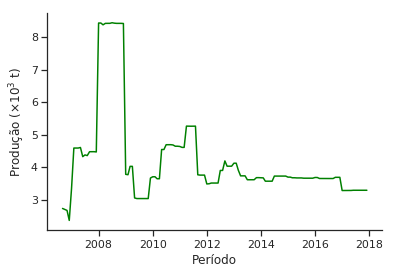

In [5]:
fig, ax = plt.subplots()
ax.plot(df_geral.loc[:, 'toneladas'], linewidth=1.5, color='green')

ax.set_ylabel('Produção (' + r'$\times10^3$ t)')
ax.set_xlabel('Período')
# ax.set_title('Produção Nacional de Guraná (2006-2017)')

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.get_offset_text().set_visible(False)
# ax.set_facecolor('#FAFAFA')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.savefig("geral.png", dpi=80, transparent=True)

### Análise da producação do guaraná, por Estados 

A ideia aqui é ter uma noção do índice de produção em cada estado.

Ajusta o nome dos estados no _dataframe_ principal e, em seguida, calcula a contruibuição de cada estado no índice de produção nacional entre 2006 e 2017:

In [6]:
df.estado = df.estado.str.upper()

# --

df_aux = df.groupby(["estado"], as_index=True).agg({"toneladas": "sum"}).sort_values('toneladas', ascending=False)
df_aux.toneladas = round((df_aux.toneladas / df_aux.toneladas.sum()) * 100, 2)
df_aux.head(10)

,toneladas
estado,
BAHIA,56.98
AMAZONAS,37.01
MATO GROSSO,5.09
PARÁ,0.48
ACRE,0.40
RONDÔNIA,0.03
SÃO PAULO,0.00
SERGIPE,0.00
SANTA CATARINA,0.00


Carrega o `shape_file` do mapa do Brasil e ajusta o nome do Estado do Espírito Santo.

In [7]:
df_map = gpd.read_file("shape_files/UFEBRASIL.shp")
df_map.NM_ESTADO = df_map.NM_ESTADO.replace("ESPIRITO SANTO", "ESPÍRITO SANTO")

Inclui as coordenadas $(X, Y)$ das capitais em `df_aux`:

In [8]:
df_xy = pd.DataFrame()
df_xy['estado']= df_map.NM_ESTADO
df_xy["x"] = df_map.centroid.map(lambda p: p.x)
df_xy["y"] = df_map.centroid.map(lambda p: p.y)

df_aux = df_aux.merge(df_xy, on='estado')

Soma valores muito pequenos (do _dataframe_ principal) à cosntante `c` para ajudar a distinguir visualmente estados produtores dos não produtores.

In [9]:
c = 10

df_make_up = df_aux[['estado', 'toneladas']].copy().set_index('estado')
df_make_up.toneladas = df_make_up.toneladas.apply(lambda x: (x+c) if 30 > x > 0 else x)

# --

df_make_up.head(10)

,toneladas
estado,
BAHIA,56.98
AMAZONAS,37.01
MATO GROSSO,15.09
PARÁ,10.48
ACRE,10.40
RONDÔNIA,10.03
SÃO PAULO,0.00
SERGIPE,0.00
SANTA CATARINA,0.00


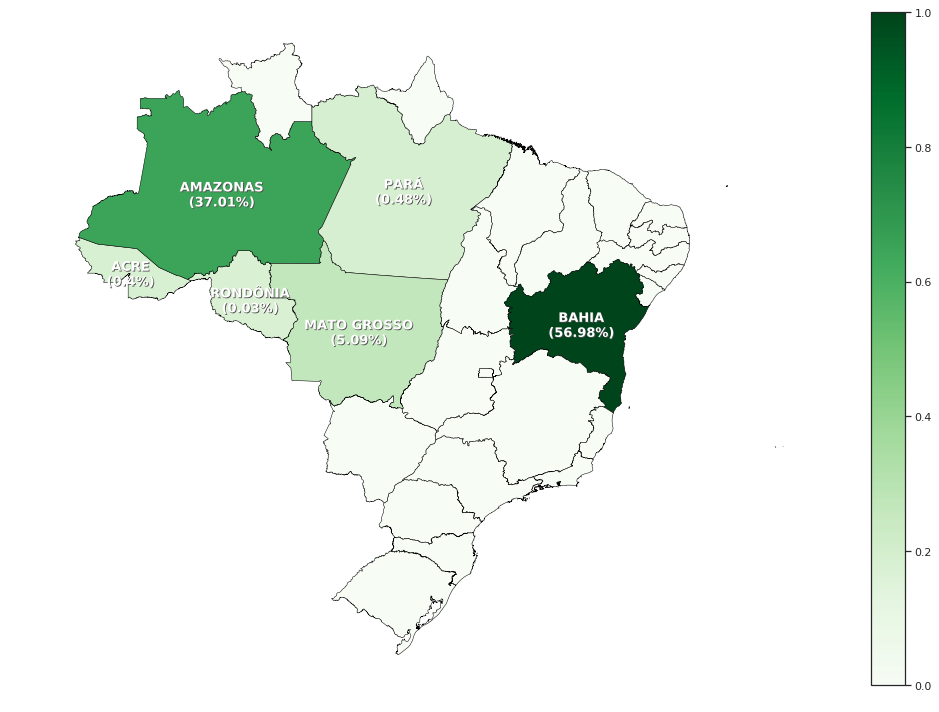

In [10]:
fig, ax = plt.subplots(1, figsize=(15, 10))

merged = df_map.set_index('NM_ESTADO').join(df_make_up)
merged.plot(column='toneladas', cmap='Greens', ax=ax, linewidth=0.5, edgecolor='.0')

# Configurações de cor
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0.0, vmax=1.0))
sm._A = []
cbar = fig.colorbar(sm)
# ax.set_facecolor('#FAFAFA')

# Labels

for _, row in df_aux.iterrows():
    if row.toneladas > 0:
        plt.text(row.x, row.y-1, "{}\n({}%)".format(row.estado, row.toneladas), 
                 fontsize=13, weight ='bold', color='white', horizontalalignment='center',
                 path_effects=[pe.withSimplePatchShadow(alpha=1, rho=.3, offset=(.8, -.8))])
    

# ax.annotate('Fonte: IBGE (2019)',xy=(0.139, .12), xycoords='figure fraction', 
#             horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')


ax.axis('off')

plt.tight_layout()
plt.savefig("por_estado.png", dpi=150, transparent=True)